

#   Projeto de análise, limpeza e predição de dados: 

<span style='color:Gray'>  Funcionários elegíveis para promoção na TurinGucci Company. </span>

Autor: Wanderson Ferreira

Descrição do dataset:

> - **employee_id:** ID único do funcionário;
>
> - **department:** departamento do funcionário;
>
> - **region:** região de emprego (não ordenada);
>
> - **education:** nível educacional do funcionário;
>
> - **gender:** gênero do funcionário
>
> - **recruitment_channel:** canal de recrutamento para o funcionário;
>
> - **no_ of_trainings:**  número de treinamentos completados em anos passados, sejam em soft skills, technical skills, etc.
>
> - **age:** idade do funcionário;
>
> - **previous_year_rating:** avaliação do funcionário para o ano anterior;
>
> - **length_of_service:** duração do serviço em anos;
>
> - **awards_won?:** se ganhou algum prêmio em anos anteriores, recebe 1, do contrário 0;
>
> - **avg_training_score:** pontuação média nas avaliações de treinamento atuais;
>
> - **is_promoted:** (Target) recomendado ou não para promoção.

In [8]:
import numpy as np # algelin 
import pandas as pd # data processing

#Data visualization 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.style as style
%matplotlib inline
import seaborn as sns
from scipy import stats

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Loading data

url_train = 'https://raw.githubusercontent.com/wanderson42/Turing-Academy-Projects/main/datasets/train.csv'
url_test = 'https://raw.githubusercontent.com/wanderson42/Turing-Academy-Projects/main/datasets/test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

#Juntando os datasets
df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])

#Primeiras impressões sobre o dataframe
df.info()
print("Shape of Train Dataset: ",train.shape)
print("Shape of Test Dataset: ",test.shape)
df.sample(n = 5).style.background_gradient(cmap = 'Set3')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78298 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           78298 non-null  int64  
 1   department            78298 non-null  object 
 2   region                78298 non-null  object 
 3   education             74855 non-null  object 
 4   gender                78298 non-null  object 
 5   recruitment_channel   78298 non-null  object 
 6   no_of_trainings       71379 non-null  float64
 7   age                   78298 non-null  int64  
 8   previous_year_rating  72362 non-null  float64
 9   length_of_service     78298 non-null  int64  
 10  awards_won?           78298 non-null  int64  
 11  avg_training_score    70840 non-null  float64
 12  ind                   78298 non-null  object 
 13  is_promoted           54808 non-null  float64
dtypes: float64(4), int64(4), object(6)
memory usage: 9.0+ MB
Shape of Trai

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,ind,is_promoted
33573,5195,Operations,region_20,Bachelor's,f,sourcing,2.000000,32,3.000000,3,0,62.000000,train,0.000000
36287,65316,Operations,region_2,Bachelor's,m,sourcing,1.000000,37,3.000000,3,0,61.000000,train,0.000000
15522,59340,Technology,region_7,Bachelor's,MALE,other,2.000000,35,3.000000,5,0,81.000000,train,0.000000
45006,61266,Sales & Marketing,region_13,Bachelor's,m,other,1.000000,38,1.000000,6,0,48.000000,train,0.000000
36934,54209,Sales & Marketing,region_25,Bachelor's,m,sourcing,1.000000,34,3.000000,7,0,47.000000,train,0.000000


Após uma noção geral de como o dataset esta estruturado, como parte da investigação inicial, segue abaixo um resumo estatístico conciso do dataset.

In [10]:
df.describe([0.1,0.2,0.4,0.6,0.8]).style.background_gradient(cmap = 'Set3')

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
count,78298.000000,71379.000000,78298.000000,72362.000000,78298.000000,78298.000000,70840.000000,54808.000000
mean,39149.500000,1.256672,201.898120,3.332219,5.848974,0.023053,63.430957,0.085170
std,22602.830026,0.610376,4538.125963,1.260982,4.248070,0.150073,13.465914,0.279137
min,1.000000,1.000000,-32.000000,1.000000,1.000000,0.000000,39.000000,0.000000
10%,7830.700000,1.000000,27.000000,1.000000,2.000000,0.000000,48.000000,0.000000
20%,15660.400000,1.000000,28.000000,2.000000,2.000000,0.000000,50.000000,0.000000
40%,31319.800000,1.000000,32.000000,3.000000,4.000000,0.000000,57.000000,0.000000
50%,39149.500000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
60%,46979.200000,1.000000,35.000000,4.000000,6.000000,0.000000,64.000000,0.000000
80%,62638.600000,1.000000,40.000000,5.000000,8.000000,0.000000,79.000000,0.000000


Conforme a distribuição de dados acima, os valores numéricos estão majoritariamente situados em torno de 40 a 100%, seguindo a tendência de uma distribuição normal. Com exceção da _feature_ **age** no dataset de treino que apresenta valores irrealistas, como por exemplo números negativos, interferindo na média (mean) e desvio padrão (std). 

In [11]:
#Investigando outliers em age no dataset de treino
unreal_employees = df[df['age'] >= 95]
print("Nº de outliers:",len(df))
print(unreal_employees['age'].sample(25))

Nº de outliers: 78298
8727     123456
25726    123456
32927    123456
35854    123456
31510    123456
35529    123456
30566    123456
5474     123456
9430     123456
54698    123456
23804    123456
48051    123456
24242    123456
45858    123456
2976     123456
39809    123456
47041    123456
36416    123456
6528     123456
40317    123456
17874    123456
429      123456
54051    123456
25503    123456
25804    123456
Name: age, dtype: int64


Após uma visão geral sobre essa _feature_ observa-se que uma quantidade expressiva desses _outliers_ são formados por uma sequência crescente de 6 algarismos, então supomos que ocorreu algum erro de digitação na construção do dataset, assim podemos suprimir esses valores que destoam da maioria definindo-se um novo intervalo de valores permitidos. 

In [12]:
df.drop(df[df['age'] < 15].index, inplace = True)
df.drop(df[df['age'] > 95].index, inplace = True)

É válido ressaltar, que na construção de um bom modelo preditivo é muito importante efetuarmos uma boa limpeza no _dataset_. Prosseguimos agora com a identificação de _missing values_.

In [13]:
# Tratando missing values em ambos os datasets

# Calculando o valor total de missing values no dataset de treino
df_total_nan = df.isna().sum()
df_percent_nan = ((df.isna().sum()/df.shape[0])*100).round(2)


# Construindo uma tabela de missing values 
table_missing_data = pd.concat([df_total_nan,df_percent_nan],
                                axis=1, 
                                keys=['Total NaN', 'Total NaN(%)'],
                                sort = True)

# lets check the head
table_missing_data.style.bar(color = 'lightcoral')

,Total NaN,Total NaN(%)
age,0,0.000000
avg_training_score,7433,9.510000
awards_won?,0,0.000000
department,0,0.000000
education,3442,4.400000
employee_id,0,0.000000
gender,0,0.000000
ind,0,0.000000
is_promoted,23443,30.000000
length_of_service,0,0.000000


Podemos ver na tabela acima que um total de 4 _features_ constituem _missing values_. Onde os _missing values_ de **length_of_service**, **no_of_trainings**, **previous_year_rating** foram substituidos pela respectiva média de cada _feature_, exceto para **education** que devido ao percentual de _missing values_ optamos por removê-los. 

In [14]:
# Substituindo missing values nas features dos datasets

df['avg_training_score'].fillna(value = df['avg_training_score'].mean(), inplace=True)

df.dropna(subset=['education'],inplace=True)

df['no_of_trainings'].fillna(value = df['no_of_trainings'].mean(), inplace=True)

df['previous_year_rating'].fillna(value = df['previous_year_rating'].mean(), inplace=True)

print("Nº de missing values presentes em todo o dataset:", df.isna().sum().sum())


Nº de missing values presentes em todo o dataset: 22410


Os _missing values_ correspondentes a referida _target_ do _dataset_ (**is_promoted**) surgem devido a junção do _dataset_ de treino com o de teste (que por sua vez não possui a coluna **is_promoted**), esses _missing values_ vão sumir assim que separarmos os _datasets_.
A partir de agora, precisamos entender como essas features se correlacionam e, especificamente, a relação entre as _features_ e a _target_. Neste contexto, é de suma importância checarmos o balanceamento de dados da variável alvo conforme se segue:

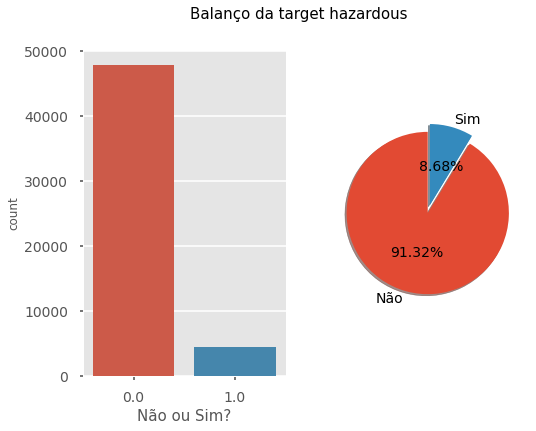

<Figure size 576x432 with 0 Axes>

In [17]:


plt.rcParams['figure.figsize'] = (8, 6); plt.style.use('ggplot'); plt.subplot(1, 2, 1); sns.countplot(df['is_promoted'])
plt.xlabel('Não ou Sim?', fontsize = 15); plt.yticks(fontsize=14); plt.xticks(fontsize=14); plt.subplot(1, 2, 2)
df['is_promoted'].value_counts().plot(kind = 'pie', explode = [0, 0.1], autopct = '%.2f%%', startangle = 90,
                                       labels = ['Não','Sim'], shadow = True, pctdistance = 0.5,fontsize=14)
plt.axis('off'); plt.suptitle('Balanço da target hazardous', fontsize = 15); plt.figure(figsize=(8, 6)); plt.show()

Analisando os gráficos dispostos acima, claramente o dataset de treino possui uma _target_ consideravelmente desbalanceada, portanto deve-se tomar as devidas precauções para que o modelo preditivo não leve a resultados completamente enviezados para a classe com a mais alta distribuição. Prosseguindo com a EDA, a seguir temos a análise estatística univariada: 

In [18]:
# Classificando as features 
catg_data = [i for i in df.columns if df[i].dtypes=='object']
nums_data = [i for i in df.columns if i not in catg_data]
print("Features categóricas:\n",catg_data,"\n")
print("Features numéricas:\n",nums_data,"\n")

Features categóricas:
 ['department', 'region', 'education', 'gender', 'recruitment_channel', 'ind'] 

Features numéricas:
 ['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 'is_promoted'] 



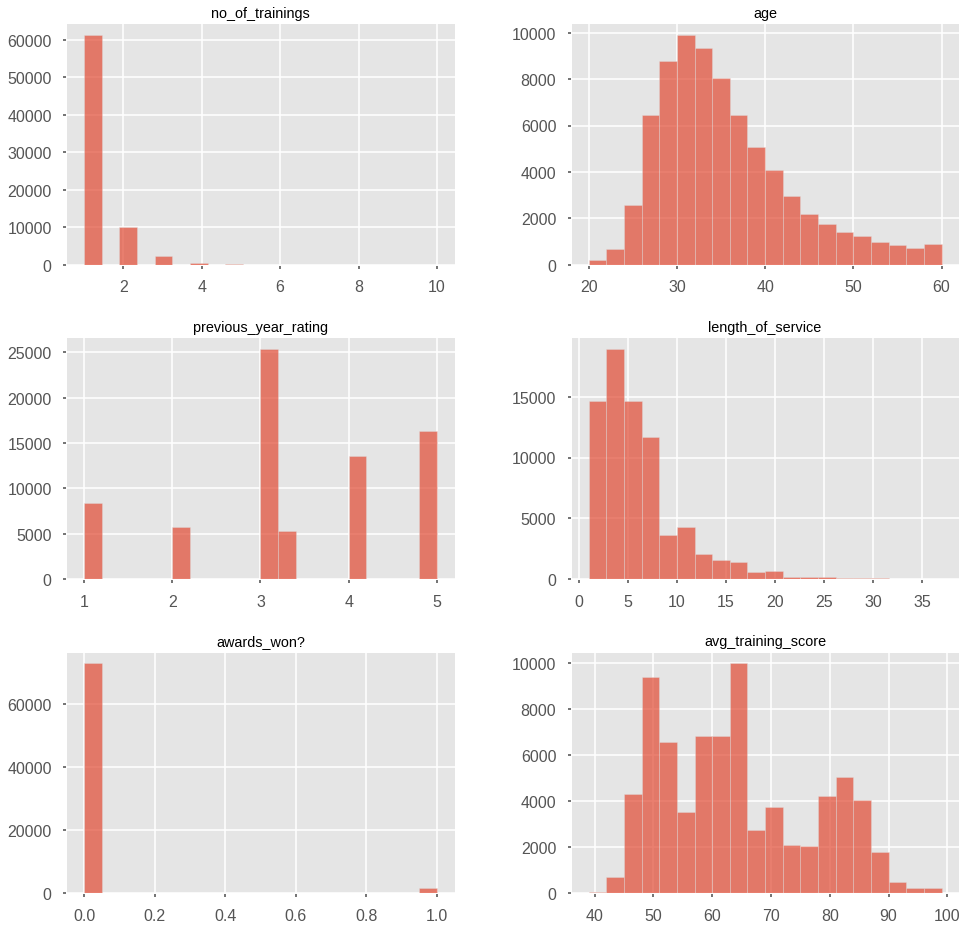

In [19]:
nums_data = df.select_dtypes(include=['int64', 'float64'])
del nums_data['is_promoted']
del nums_data['employee_id']
#del nums_data['ind']
nums_data.hist(bins=20, figsize=(16,16), edgecolor='#e0e0e0', alpha=0.7, linewidth=0.5)
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})
plt.show()

Conforme a distribuição de dados nos histogramas acima, pode-se destacar:

> - Na _feature_ **no_of_trainings**, cerca de 80% dos funcionários fizeram apenas um treinamento, e há um número inexpressível de funcionários que fizeram treinamentos mais de três vezes. E a pontuação média de 50% foi obtida por uma quantidade expressiva de funcionários nessas avaliações de treinamento (**avg_training_score**).
>
> - A maioria dos funcionários tem uma avaliação anual muito baixa em relação ao ano anterior (**previous_year_rating**), e a minoria deles (aprox. 2% deles) estão mais propensos a receber bonificação pelo seu trabalho (**awards_won?**), cuja estatistica está dentro da normalidade.
>
> - O quadro de funcionários majoritariamente possui idade (**age**) em torno de 28 a 38 anos.  De acordo com a distribuição da feature **length_of_service**, a grande maioria de funcionários da _TuringGucci_ trabalham na empresa no máximo há 8 anos, cujo o tempo de serviço de 5 anos é o mais frequente entre os funcionários.  

Por conseguinte, agora exploramos algumas features categóricas.

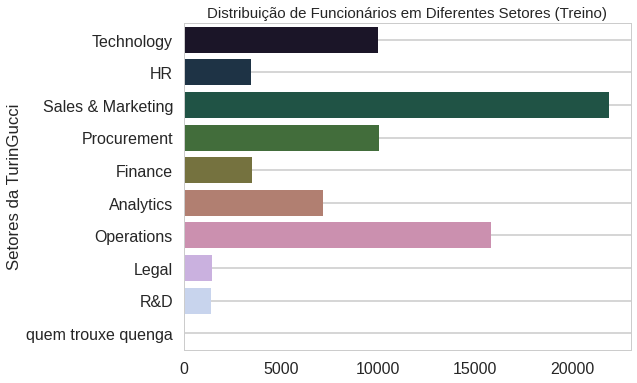

In [21]:
def plot1():
    plt.rcParams['figure.figsize'] = (8, 6)
    sns.countplot(y = df['department'], palette = 'cubehelix', orient = 'v')
    plt.xlabel(''); plt.ylabel('Setores da TurinGucci')
    plt.title('Distribuição de Funcionários em Diferentes Setores (Treino)', fontsize = 15)
    plt.grid(); plt.show()
plot1()

Em relação à distribuição de funcionários em diferentes setores da firma (conforme o gráfico acima), o setor de marketing e vendas detem o maior número de colaboradores, precedidos pelo setor de operações, estas duas categorias correspondem quase a metade do quadro de funcionários da TurinGucci. 

OBS: Notamos que existe algum comediante na equipe responsável pela construção do dataset, assim omitimos o setor "quem trouxe quenga" em ambos os datasets.

In [22]:
df = df[~df.isin(['quem trouxe quenga']).any(axis=1)]

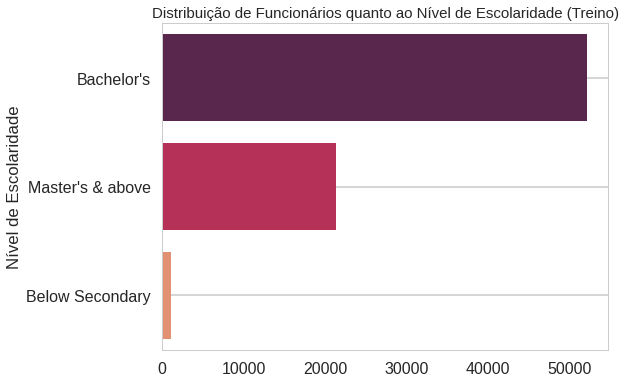

In [24]:
def plot1():
    plt.rcParams['figure.figsize'] = (8, 6)
    sns.countplot(y = df['education'], palette = 'rocket', orient = 'v')
    plt.xlabel(''); plt.ylabel('Nível de Escolaridade')
    plt.title('Distribuição de Funcionários quanto ao Nível de Escolaridade (Treino)', fontsize = 15)
    plt.grid(); return plt.show()
plot1()

Observa-se no gráfico acima, que mais da metade do quadro de funcionários apresentam formação em nível de bacharelado. A quantidade de funcionários que possuem diploma de mestrado (ou nível maior) também é expressiva. E o nível de escolaridade abaixo do 2º grau é o menos frequente.

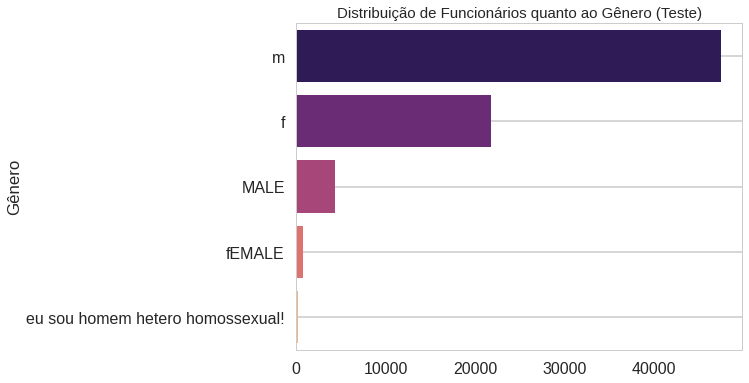

In [25]:
def plot1():
    plt.rcParams['figure.figsize'] = (8, 6)
    sns.countplot(y = df['gender'], palette = 'magma', orient = 'v')
    plt.xlabel(''); plt.ylabel('Gênero')
    plt.title('Distribuição de Funcionários quanto ao Gênero (Teste)', fontsize = 15)
    plt.grid(); return plt.show()
plot1()

Como podemos observar, o gênero feminino (_female_) é minoria na empresa em comparação ao gênero masculino (_male_). Contudo, temos algumas inconsistências de dados nessa _feature_. Os pares "m" e "MALE", "f" e "fEMALE", respectivamente referem-se a mesma classe. Assim, é necessário fazermos ajustes.  

OBS: O humor da 5ª serie ataca novamente, assim omitimos do _dataset_ o gênero "eu sou homem hetero homossexual!"

In [27]:
#Renomeando as classes
df['gender'] = df['gender'].replace({"MALE": "m", "fEMALE": "f"})
df['gender'] = df['gender'].replace({"m": "Male", "f": "Female"})

#Deletando a classe incoerente
df = df[~df.isin(['eu sou homem hetero homossexual!']).any(axis=1)]

Prosseguimos agora com a ánalise estatística bivariada, começando pela análise conjunta entre gênero e promoção.

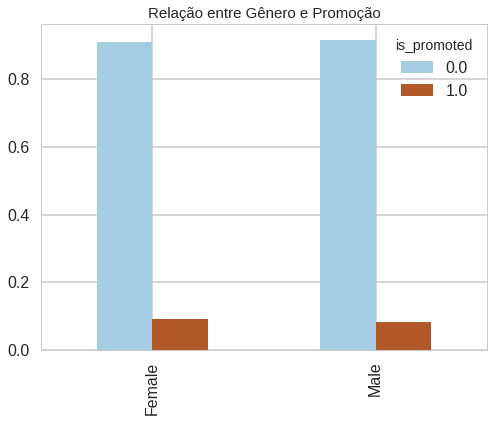

In [29]:
plt.rcParams['figure.figsize'] = (8, 6); x = pd.crosstab(df['gender'], df['is_promoted'],normalize='index')
colors = plt.cm.Wistia(np.linspace(0, 1, 5)); x.plot(kind = 'bar', stacked = False, colormap='Paired')
plt.title('Relação entre Gênero e Promoção', fontsize = 15); plt.xlabel(' '); plt.show()

Conforme a distribuição homogênea no gráfico acima, é notório que na TuringGucci o gênero não é um fator determinante para obter-se uma promoção na companhia.

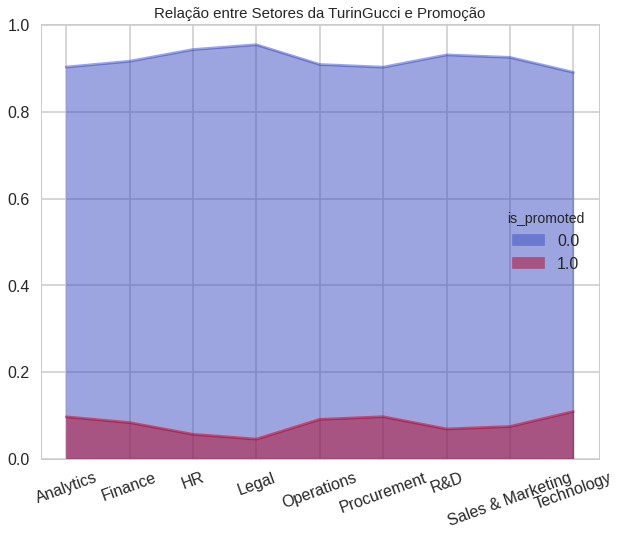

In [31]:
# lets compare the effect of different Departments and Promotion
plt.rcParams['figure.figsize'] = (10, 8); x = pd.crosstab(df['department'], df['is_promoted'],normalize='index')
colors = plt.cm.copper(np.linspace(0, 1, 3)); x.plot(kind = 'area', stacked = False,colormap='coolwarm')
plt.title('Relação entre Setores da TurinGucci e Promoção', fontsize = 15); plt.xticks(rotation = 20); plt.xlabel(' '); plt.show()

Novamente, de acordo com o gráfico acima, temos um aspecto homogêneo, agora para a distribuição conjunta entre setores da TurinGucci e promoção. Dando continuidade, agora com uma ánalise multivariada, a seguir construimos uma matriz de correlação entre _features_:

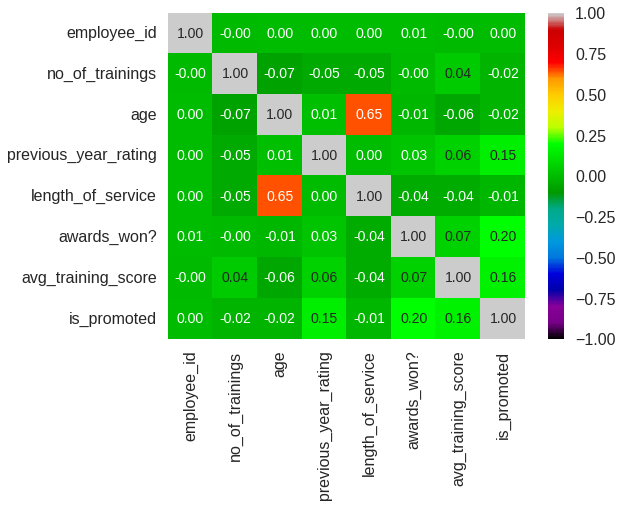

In [32]:
plt.figure(figsize=(8, 6)); sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f',cmap="nipy_spectral"); plt.show()

A partir da matriz acima, conforme a escala do coeficiente de pearson, podemos observar resultados óbvios, como a correlação moderada entre idade (**age**) e tempo de serviço (**length_of_service**). No entanto, identifica-se que a maioria das correlações  entre a _features_ são bem fracas ou fracas, ou seja, é bem pouco provável que tais _features_ afetem umas as outras.

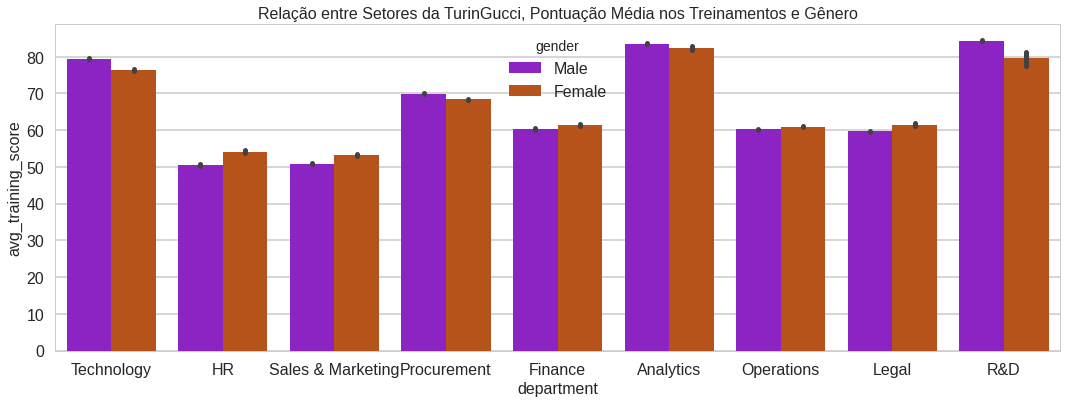

In [37]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.barplot(df['department'], df['avg_training_score'], hue = df['gender'], palette = 'gnuplot')
plt.title('Relação entre Setores da TurinGucci, Pontuação Média nos Treinamentos e Gênero', fontsize = 16)
plt.ylabel('avg_training_score', fontsize = 16)
plt.xlabel('department', fontsize = 16)
plt.show()

Analizando os setores da TuringGucci juntamente com a pontuação média nos treinamentos e gênero (gráfico acima), destaca-se que as médias de desempenho apartir de 70% (que podem ser consideradas como muito boas) são obtidas pelos setores de Tecnologia, Inteligência analítica e P&D. Também observa-se que na maioria dos setores o gênero masculino obteve uma pontuação sutilmente maior.

Após a análise de diversas _features_ sob o ponto de vista da estatística descritiva, bem como a transformação matemática sobre as _features_ (quando necessaria) para extrair o máximo potencial dos dados, agora temos propriedade para definir quais _features_ são necessárias para construir o modelo. Contudo, ainda necessitamos aplicar algumas técnicas de _feature engineering_ para melhorar nosso modelo. Conforme se segue:

In [40]:
#Preprocessamento de dados 
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Excluindo features com baixo poder preditivo.
df.drop(['recruitment_channel', 'region', 'employee_id'], inplace=True, axis=1)

#Binarização
df['gender'] = df['gender'].replace({'Female':0, 'Male':1})

# lets use Label Encoding for Department to convert them into Numerical  
df['department'] = LabelEncoder().fit_transform(df['department'])

#Codificação de rótulo 
edu_ranking = {"Master's & above" : 1, "Bachelor's" : 2 , "Below Secondary" : 3}

df['education'] = df['education'].map(edu_ranking)

#separar o dataset de treino e teste
test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]
del train['ind']
del test['ind']
#Excluindo  is_promoted do dataset de teste que surgiu devido a junção dos datasets
del test['is_promoted']

print("Shape of Train Dataset: ",train.shape)
print("Shape of Test Dataset: ",test.shape)

Shape of Train Dataset:  (52041, 10)
Shape of Test Dataset:  (22403, 9)


A seguir efetuamos a divisão dos dados, onde 70% será usado para treino e 30% dos dados serão reservados para teste. Além disso, implementamos um recurso muito útil em problemas de classificação que é uma padronização nas _features_ por meio do StandardScaler() que subtrai a média e, em seguida, dimensiona para a variação de unidade. A variação de unidade significa dividir todos os valores pelo desvio padrão. Isso resulta em uma distribuição com um desvio padrão igual a 1 (variância também igual a 1) e média igual a 0.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# lets split the target data from the train data
y = train['is_promoted']
X = train.drop(['is_promoted'], axis = 1)

#Padronização de recursos
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Dividindo o dataset numa base de treino e base de teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True, stratify=y,)

#Agora implemetamos o método SMOTE para fazer o balanceamento dos dados.
#smote = SMOTE(random_state = 42)
#Oversampling nos Dados desbalanceados (treino)
#X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train.values.ravel())


Para as métricas de avaliação dos modelos utilizaremos a acurácia, matriz de confusão e curva ROC.

In [42]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score , recall_score, f1_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
class_names=np.array(['0','1'])

# Function to plot the confusion Matrix
def plot_confusion_matrix(cf_matrix):            
    group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(8,6)); ax = sns.heatmap(cf_matrix, annot=labels, fmt='',annot_kws={"fontsize":13},cmap="coolwarm")
    ax.set_title('Matriz de Confusão'); ax.set_xlabel('\nPredito', fontsize=14); ax.set_ylabel('Real', fontsize=14);
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Não Promovido','Promovido'],fontsize=14)
    ax.yaxis.set_ticklabels(['Não Promovido','Promovido'],fontsize=14)
    ## Display the visualization of the Confusion Matrix.
    plt.show()

Com relação ao treinamento do modelo adotamos os seguintes algoritmos de aprendizagem supervisionada: Regressão Logística, K — Nearest Neighbors, Decision Tree, Random forest e  Gradient Boosting Machine. Em ordem, a seguir implementaremos esses algortimos um de cada vez com os seus respectivos resultados na avaliação de métricas. 

In [45]:
#Treinar o modelo nos dados de treino com regressão logistica (rl)
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression(class_weight='balanced', solver='liblinear')
rl.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

Avaliando o modelo nos dados de treino 
Regressão Logistica Accuracia = 67.10%
Avaliando o modelo nos dados de teste 
Regressão Logistica Accuracia = 67.26%


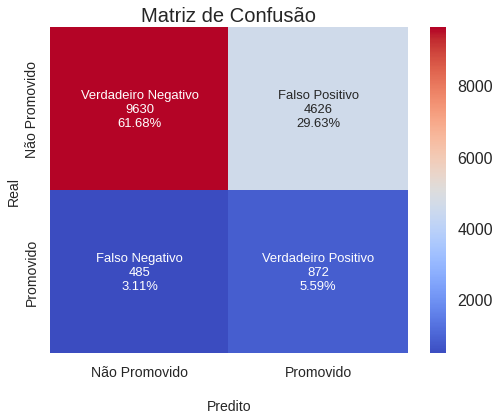

In [46]:
#---------------------Predizer os dados de treino----------------------
print("\033[1mAvaliando o modelo nos dados de treino \033[0m")
y_pred_train_rl = rl.predict(X_train)
#accuracy on LR
accuracy = metrics.accuracy_score(y_train,y_pred_train_rl)
print ('Regressão Logistica Accuracia' + ' = {:.2f}%'.format(accuracy * 100))

#--------------------Predizer os dados de teste-----------------------
print("\033[1mAvaliando o modelo nos dados de teste \033[0m")
y_pred_test_rl = rl.predict(X_test)
#accuracy on LR
accuracy = metrics.accuracy_score(y_test,y_pred_test_rl)
print ('Regressão Logistica Accuracia' + ' = {:.2f}%'.format(accuracy * 100))
#confusion matrix on LR
cf_matrix = metrics.confusion_matrix(y_test, y_pred_test_rl)
plot_confusion_matrix(cf_matrix)

A partir da análise dos resultados acima, podemos ver que o modelo de regressão logistica (RL) nos leva a uma acurácia práticamente identica tanto para os dados de treino como o de teste, onde 2/3 dos estudos de caso de fato foram classificados corretamente, independente da classe. E vizualizando a perfomance do modelo no _dateset_ de teste por meio da matriz de confusão, estimamos que aproximadamente 5% dos funcionários foram classificados como "verdadeiro positivo", isto é, merecem uma promoção na companhia e cerca de 61% dos funcionários o modelo previu corretamente como "verdadeiro negativo", ou seja, não merecem uma promoção. Quanto ao erro de previsão o modelo atribuiu apenas 3% dos funcionários como "falso negativo", ou seja, 3% que o modelo erroneamente previu que não mereciam a promoção e em torno de 30% foram classificados como "falso positivo", isto é, a cada 100 funcionários que foram promovidos, 30 deles não mereciam a promoção. 

Seguimos agora com a implementação do algoritmo K — Nearest Neighbors (KNN).



In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

Avaliando o modelo nos dados de treino: 
KNN Accuracia = 92.63%

Avaliando o modelo nos dados de teste: 
KNN Accuracia = 91.88%


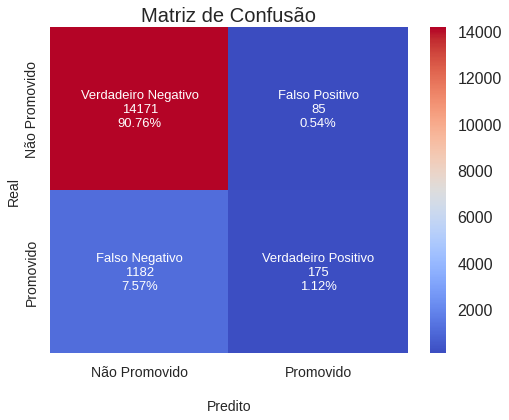

In [49]:
#---------------------Predizer os dados de treino----------------------
print("\033[1mAvaliando o modelo nos dados de treino: \033[0m")
y_pred_train_knn = knn.predict(X_train)
#accuracy on KNN
accuracy = metrics.accuracy_score(y_train, y_pred_train_knn)
print ('KNN Accuracia' + ' = {:.2f}%'.format(accuracy * 100))
print()

#--------------------Predizer os dados de teste-----------------------
print("\033[1mAvaliando o modelo nos dados de teste: \033[0m")
y_pred_test_knn = knn.predict(X_test)
#accuracy on KNN
accuracy = metrics.accuracy_score(y_test,y_pred_test_knn)
print ('KNN Accuracia' + ' = {:.2f}%'.format(accuracy * 100))

#confusion matrix on KNN
cf_matrix = metrics.confusion_matrix(y_test, y_pred_test_knn)
plot_confusion_matrix(cf_matrix) 

Conforme os resultados das métricas, de modo geral o KNN  resultados bem melhores que o modelo de RL. Prosseguindo agora com o algoritmo Decision Tree (DT).

In [51]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=3, min_samples_leaf=5)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

Avaliando o modelo nos dados de treino: 
Decision Tree Accuracia = 92.06%
Avaliando o modelo nos dados de teste: 
Decision Tree Accuracia = 91.94%


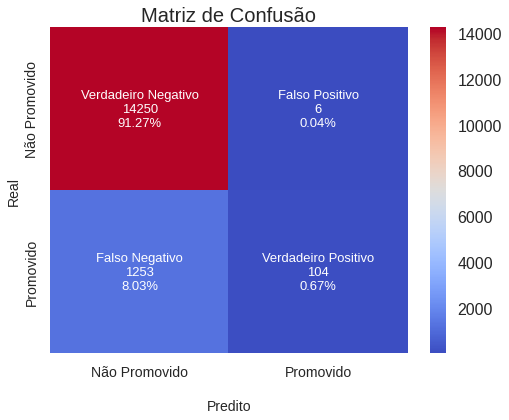

In [52]:
#---------------------Predizer os dados de treino----------------------
print("\033[1mAvaliando o modelo nos dados de treino: \033[0m")
y_pred_train_dtree = dtree.predict(X_train)
#accuracy on LR
accuracy = metrics.accuracy_score(y_train,y_pred_train_dtree)
print ('Decision Tree Accuracia' + ' = {:.2f}%'.format(accuracy * 100))

#--------------------Predizer os dados de teste-----------------------
print("\033[1mAvaliando o modelo nos dados de teste: \033[0m")
y_pred_train_dtree = dtree.predict(X_test)
#accuracy on DT
accuracy = metrics.accuracy_score(y_test,y_pred_train_dtree)
print ('Decision Tree Accuracia' + ' = {:.2f}%'.format(accuracy * 100))

#confusion matrix on DT
cf_matrix = metrics.confusion_matrix(y_test, y_pred_train_dtree)
plot_confusion_matrix(cf_matrix)

Nos dados de treino as métricas do KNN são quase identicas ao modelo de DT. A seguir implementamos o algoritmo Random Forest (RT) para treinamento do modelo.

In [54]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
rf = RandomForestClassifier(max_depth=25, n_estimators=300, min_samples_split=50, criterion='entropy', oob_score=True, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_split=50,
                       n_estimators=300, oob_score=True, random_state=42)

Avaliando o modelo nos dados de treino:
Random Forest Accuracia = 93.53%
Avaliando o modelo nos dados de teste: 
Random Forest Accuracia = 92.94%


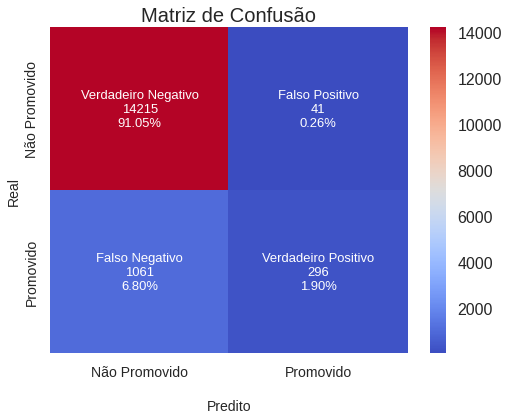

In [56]:
#---------------------Predizer os dados de treino----------------------
print("\033[1mAvaliando o modelo nos dados de treino:\033[0m")
y_pred_train_rf = rf.predict(X_train)
#accuracy on RF
accuracy = metrics.accuracy_score(y_train,y_pred_train_rf)
print ('Random Forest Accuracia' + ' = {:.2f}%'.format(accuracy * 100))

#--------------------Predizer os dados de teste-----------------------
print("\033[1mAvaliando o modelo nos dados de teste: \033[0m")
y_pred_test_rf = rf.predict(X_test)
#accuracy on RF
accuracy = metrics.accuracy_score(y_test,y_pred_test_rf)
print ('Random Forest Accuracia' + ' = {:.2f}%'.format(accuracy * 100))

#confusion matrix on RF
cf_matrix = metrics.confusion_matrix(y_test, y_pred_test_rf)
plot_confusion_matrix(cf_matrix)

Aqui o RF apresenta uma acurácia sutilmente superior em relação aos algoritmos KNN e DT, onde os _scores_ de erro da matriz confusão são um pouco melhores. Por fim, implementamos agora o ultimo algoritmo de treinamento do modelo que é o Gradient Boosting (GB).

In [57]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=51, max_depth=3, learning_rate=.71)
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.71, n_estimators=51)

Avaliando o modelo nos dados de treino:
Gradient Boosting Accuracia = 93.88%
Avaliando o modelo nos dados de teste:
Gradient Boosting Accuracia = 93.29%


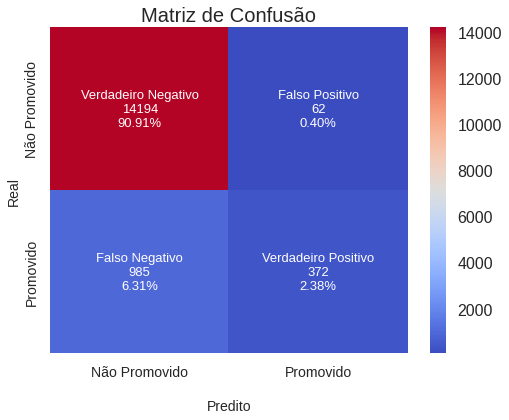

In [59]:
#---------------------Predizer os dados de treino----------------------
print("\033[1mAvaliando o modelo nos dados de treino:\033[0m")
y_pred_train_gb = gb.predict(X_train)
#accuracy on GB
accuracy = metrics.accuracy_score(y_train,y_pred_train_gb)
print ('Gradient Boosting Accuracia' + ' = {:.2f}%'.format(accuracy * 100))

#--------------------Predizer os dados de teste-----------------------
print("\033[1mAvaliando o modelo nos dados de teste:\033[0m")
y_pred_test_gb = gb.predict(X_test)
#accuracy on GB
accuracy = metrics.accuracy_score(y_test,y_pred_test_gb)
print ('Gradient Boosting Accuracia' + ' = {:.2f}%'.format(accuracy * 100))

#confusion matrix on RF
cf_matrix = metrics.confusion_matrix(y_test, y_pred_test_gb)
plot_confusion_matrix(cf_matrix)

Aqui observamos que o GB apresenta resultados muito similares ao RT com a vantagem de ter uma perfomance melhor no que se diz respeito ao custo computacional. 

A seguir vamos fazer uma comparação estatística entre os modelos através da curva ROC (_Receiver Operating Characteristic Curve_) que mostra o quão bom o modelo criado pode distinguir entre classes positivas e negativas. Uma curva ROC traça as taxas “verdadeiro positivo vs. falso positivo” em diferentes limiares de classificação, Vejamos a figura abaixo. 

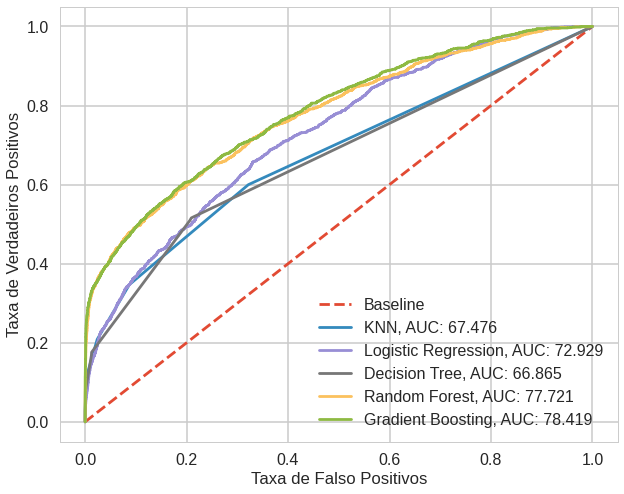

In [60]:
from sklearn.metrics import roc_curve
fig, ax = plt.subplots(figsize=(10,8))

lr_probs = rl.predict_proba(X_test)[:, 1] # LR
knn_probs = knn.predict_proba(X_test)[:, 1] # KNN
dtree_probs = dtree.predict_proba(X_test)[:, 1] # dtree
rf_probs = rf.predict_proba(X_test)[:, 1] # RF
Gb_probs = gb.predict_proba(X_test)[:, 1] # GB
# plot baseline roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline')
# calculate roc curve for model
fpr1, tpr1, _ = roc_curve(y_test, knn_probs)
fpr2, tpr2, _ = roc_curve(y_test, lr_probs )
fpr3, tpr3, _ = roc_curve(y_test, dtree_probs)
fpr4, tpr4, _ = roc_curve(y_test, rf_probs )
fpr5, tpr5, _ = roc_curve(y_test, Gb_probs)
auc1 = round(100*(roc_auc_score(y_test, knn_probs)), 3)
auc2 = round(100*(roc_auc_score(y_test,lr_probs)), 3)
auc3 = round(100*(roc_auc_score(y_test,dtree_probs)), 3)
auc4 = round(100*(roc_auc_score(y_test, rf_probs)), 3)
auc5 = round(100*(roc_auc_score(y_test, Gb_probs)), 3)
# plot model roc curve
plt.plot(fpr1, tpr1, linestyle='-', label=f'KNN, AUC: {auc1}')
plt.plot(fpr2, tpr2, linestyle='-', label=f'Logistic Regression, AUC: {auc2}')
plt.plot(fpr3, tpr3, linestyle='-', label=f'Decision Tree, AUC: {auc3}')
plt.plot(fpr4, tpr4, linestyle='-', label=f'Random Forest, AUC: {auc4}')
plt.plot(fpr5, tpr5, linestyle='-', label=f'Gradient Boosting, AUC: {auc5}')
# axis labels
plt.xlabel('Taxa de Falso Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
# show the legend
plt.legend()
# show the plot
plt.show()


Uma medida decorrente da curva ROC é o AUC (Area Under the Curve), que nada mais é que a área abaixo da curva. O AUC varia entre 0 e 1, por exemplo AUC = 1 representa um modelo que fez todas as previsões perfeitamente. Portanto, com base em nossa análise comparativa da curva ROC (gráfico acima) e percentual do AUC, Gradient Boosting e Random Forest mostram as pontuações médias mais altas de AUC. 

**Conclusão** 

Em termos gerais, baseando-se em todas as métricas obtidas nos dados de teste para uma gama de algoritimos de aprendizagem supervisionada, o Gradient Boosting é o modelo mais vantajoso para predizer a elegibilidade de funcionários para promoção na TurinGucci Company. Valendo-se destacar nossa compreensiva análise exploratória de dados, bem como a criteriosa aplicação de técnicas de Engenharia de atributos para que a empresa possa ter confiança na abordagem, classificação e abrangência do referido modelo proposto para tomada de decisões.